In [22]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_MLPenhance.pth'


In [23]:
# Define CustomMLP with more complexity
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=4, dropout_prob=0.3):
        super(CustomMLP, self).__init__()

        # Store the number of layers
        self.num_layers = num_layers

        # Define the first down and gate layers
        self.down1 = nn.Linear(input_dim, hidden_dim)
        self.gate1 = nn.Linear(input_dim, hidden_dim)

        # Create additional layers dynamically
        self.down_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)
        ])
        self.gate_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)
        ])

        # Add batch normalization for each layer
        self.batch_norm_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)
        ])

        # Add residual connection for each layer
        self.residual_connections = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim) if i == 0 else nn.Identity() 
            for i in range(num_layers)
        ])

        # Final output layer
        self.up = nn.Linear(hidden_dim, 1)

        # Activation function (Swish/SiLU)
        self.activation = nn.SiLU()

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # First layer with down/gate and residual connection
        down_output = self.down1(x)
        gate_output = self.gate1(x)
        gated_output = down_output * self.activation(gate_output)

        # Residual connection for first layer
        residual = self.residual_connections[0](x)
        gated_output = gated_output + residual

        # Apply batch normalization
        gated_output = self.batch_norm_layers[0](gated_output)

        # Process through additional layers
        for i in range(1, self.num_layers):
            down_output = self.down_layers[i - 1](gated_output)
            gate_output = self.gate_layers[i - 1](gated_output)
            gated_output = down_output * self.activation(gate_output)

            # Residual connection
            residual = self.residual_connections[i](gated_output)
            gated_output = gated_output + residual

            # Batch normalization
            gated_output = self.batch_norm_layers[i](gated_output)

            # Dropout regularization
            gated_output = self.dropout(gated_output)

        # Final output layer
        output = self.up(gated_output)
        return output

In [24]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [25]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [26]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    print(f"Best Classification Report {report}")
    return custom_mlp, losses, best_accuracy

In [27]:
# def main for reference embedding/train
def main(model_name, non_infringement_file, infringement_file, checkpoint_path):
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
    tokenizer.pad_token = tokenizer.eos_token
    bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
    bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
    bert_tokenizer.pad_token = tokenizer.eos_token

    non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
        non_infringement_file, infringement_file
    )

    y_non_infringement = np.array(y_non_infringement)
    y_infringement = np.array(y_infringement)

    print("Extracting hidden states for non_infringement texts...")
    X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
    print("Extracting reference embeddings for non_infringement texts...")
    reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
    X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

    print("Extracting hidden states for infringement texts...")
    X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
    print("Extracting reference embeddings for infringement texts...")
    reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
    X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

    split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
    X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
    X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
    y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
    y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

    split_index_infringement = int(0.8 * len(X_infringement_combined))
    X_infringement_train = X_infringement_combined[:split_index_infringement]
    X_infringement_test = X_infringement_combined[split_index_infringement:]
    y_infringement_train = y_infringement[:split_index_infringement]
    y_infringement_test = y_infringement[split_index_infringement:]

    X_train = np.vstack((X_non_infringement_train, X_infringement_train))
    X_test = np.vstack((X_non_infringement_test, X_infringement_test))
    y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
    y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

    input_dim = X_train.shape[1]
    hidden_dim = 256 
    print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

    best_model, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 12/12 [17:36<00:00, 88.03s/it]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 12/12 [17:33<00:00, 87.80s/it]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   2%|▏         | 8/500 [00:00<00:38, 12.68it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Epoch 10/500, Loss: 0.6876
Test Accuracy at Epoch 10: 51.29%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581

New best model saved with accuracy 51.29% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:   4%|▎         | 18/500 [00:01<00:34, 14.17it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 20/500, Loss: 0.6764
Test Accuracy at Epoch 20: 51.29%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:   6%|▌         | 28/500 [00:02<00:33, 13.99it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 30/500, Loss: 0.6750
Test Accuracy at Epoch 30: 51.29%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:   8%|▊         | 38/500 [00:03<00:34, 13.55it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 40/500, Loss: 0.6656
Test Accuracy at Epoch 40: 51.29%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  10%|▉         | 48/500 [00:03<00:31, 14.26it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 50/500, Loss: 0.6497
Test Accuracy at Epoch 50: 51.29%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  12%|█▏        | 58/500 [00:04<00:38, 11.60it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 60/500, Loss: 0.6381
Test Accuracy at Epoch 60: 51.29%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  14%|█▎        | 68/500 [00:05<00:32, 13.26it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 70/500, Loss: 0.6295
Test Accuracy at Epoch 70: 51.29%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  16%|█▌        | 78/500 [00:06<00:35, 12.01it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 80/500, Loss: 0.6229
Test Accuracy at Epoch 80: 51.29%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       283
non_infringement       0.51      1.00      0.68       298

        accuracy                           0.51       581
       macro avg       0.26      0.50      0.34       581
    weighted avg       0.26      0.51      0.35       581



Training Epochs:  18%|█▊        | 92/500 [00:07<00:28, 14.37it/s]

Epoch 90/500, Loss: 0.6169
Test Accuracy at Epoch 90: 45.61%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.47      0.82      0.60       283
non_infringement       0.39      0.11      0.17       298

        accuracy                           0.46       581
       macro avg       0.43      0.47      0.38       581
    weighted avg       0.43      0.46      0.38       581



Training Epochs:  20%|██        | 102/500 [00:07<00:30, 13.15it/s]

Epoch 100/500, Loss: 0.6100
Test Accuracy at Epoch 100: 44.06%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.46      0.83      0.59       283
non_infringement       0.30      0.07      0.11       298

        accuracy                           0.44       581
       macro avg       0.38      0.45      0.35       581
    weighted avg       0.38      0.44      0.35       581



Training Epochs:  22%|██▏       | 112/500 [00:08<00:28, 13.74it/s]

Epoch 110/500, Loss: 0.6025
Test Accuracy at Epoch 110: 46.47%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.47      0.88      0.62       283
non_infringement       0.38      0.07      0.12       298

        accuracy                           0.46       581
       macro avg       0.43      0.48      0.37       581
    weighted avg       0.43      0.46      0.36       581



Training Epochs:  24%|██▍       | 122/500 [00:09<00:28, 13.14it/s]

Epoch 120/500, Loss: 0.5938
Test Accuracy at Epoch 120: 45.61%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.47      0.86      0.61       283
non_infringement       0.35      0.07      0.12       298

        accuracy                           0.46       581
       macro avg       0.41      0.47      0.36       581
    weighted avg       0.41      0.46      0.36       581



Training Epochs:  26%|██▋       | 132/500 [00:10<00:27, 13.23it/s]

Epoch 130/500, Loss: 0.5694
Test Accuracy at Epoch 130: 48.36%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.48      0.88      0.62       283
non_infringement       0.48      0.10      0.17       298

        accuracy                           0.48       581
       macro avg       0.48      0.49      0.40       581
    weighted avg       0.48      0.48      0.39       581



Training Epochs:  28%|██▊       | 142/500 [00:10<00:27, 13.19it/s]

Epoch 140/500, Loss: 0.5273
Test Accuracy at Epoch 140: 47.33%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.48      0.79      0.59       283
non_infringement       0.46      0.17      0.25       298

        accuracy                           0.47       581
       macro avg       0.47      0.48      0.42       581
    weighted avg       0.47      0.47      0.42       581



Training Epochs:  30%|███       | 150/500 [00:11<00:27, 12.58it/s]

Epoch 150/500, Loss: 0.3849
Test Accuracy at Epoch 150: 64.89%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.63      0.68      0.65       283
non_infringement       0.67      0.62      0.64       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

New best model saved with accuracy 64.89% at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.63      0.68      0.65       283
non_infringement       0.67      0.62      0.64       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  32%|███▏      | 160/500 [00:12<00:27, 12.55it/s]

Epoch 160/500, Loss: 0.2763
Test Accuracy at Epoch 160: 67.99%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.70      0.60      0.65       283
non_infringement       0.67      0.76      0.71       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

New best model saved with accuracy 67.99% at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.70      0.60      0.65       283
non_infringement       0.67      0.76      0.71       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581



Training Epochs:  34%|███▍      | 172/500 [00:13<00:24, 13.32it/s]

Epoch 170/500, Loss: 0.2249
Test Accuracy at Epoch 170: 64.54%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.64      0.61      0.63       283
non_infringement       0.65      0.68      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  36%|███▋      | 182/500 [00:13<00:23, 13.30it/s]

Epoch 180/500, Loss: 0.1984
Test Accuracy at Epoch 180: 66.09%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.69      0.55      0.61       283
non_infringement       0.64      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  38%|███▊      | 192/500 [00:14<00:22, 13.40it/s]

Epoch 190/500, Loss: 0.1816
Test Accuracy at Epoch 190: 66.27%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.71      0.52      0.60       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  40%|████      | 202/500 [00:15<00:21, 13.73it/s]

Epoch 200/500, Loss: 0.1767
Test Accuracy at Epoch 200: 65.06%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.70      0.49      0.58       283
non_infringement       0.62      0.80      0.70       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.64       581



Training Epochs:  42%|████▏     | 212/500 [00:16<00:20, 14.15it/s]

Epoch 210/500, Loss: 0.1682
Test Accuracy at Epoch 210: 64.37%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.68      0.51      0.58       283
non_infringement       0.62      0.77      0.69       298

        accuracy                           0.64       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.64      0.64       581



Training Epochs:  44%|████▍     | 222/500 [00:16<00:21, 13.21it/s]

Epoch 220/500, Loss: 0.1605
Test Accuracy at Epoch 220: 64.72%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.68      0.51      0.59       283
non_infringement       0.63      0.78      0.69       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  46%|████▋     | 232/500 [00:17<00:17, 14.91it/s]

Epoch 230/500, Loss: 0.1629
Test Accuracy at Epoch 230: 64.54%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.68      0.51      0.58       283
non_infringement       0.62      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  48%|████▊     | 242/500 [00:18<00:17, 14.34it/s]

Epoch 240/500, Loss: 0.1623
Test Accuracy at Epoch 240: 67.47%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.73      0.53      0.62       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.67      0.67       581



Training Epochs:  50%|█████     | 252/500 [00:19<00:17, 14.17it/s]

Epoch 250/500, Loss: 0.1589
Test Accuracy at Epoch 250: 66.61%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.61       283
non_infringement       0.64      0.79      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  52%|█████▏    | 262/500 [00:19<00:18, 12.99it/s]

Epoch 260/500, Loss: 0.1547
Test Accuracy at Epoch 260: 64.72%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       283
non_infringement       0.63      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  54%|█████▍    | 272/500 [00:20<00:16, 13.53it/s]

Epoch 270/500, Loss: 0.1577
Test Accuracy at Epoch 270: 66.27%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.73      0.49      0.59       283
non_infringement       0.63      0.83      0.72       298

        accuracy                           0.66       581
       macro avg       0.68      0.66      0.65       581
    weighted avg       0.68      0.66      0.65       581



Training Epochs:  56%|█████▋    | 282/500 [00:21<00:16, 12.98it/s]

Epoch 280/500, Loss: 0.1535
Test Accuracy at Epoch 280: 65.92%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.70      0.52      0.60       283
non_infringement       0.64      0.79      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.65       581



Training Epochs:  58%|█████▊    | 290/500 [00:21<00:14, 14.08it/s]

Epoch 290/500, Loss: 0.1558
Test Accuracy at Epoch 290: 64.37%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.67      0.53      0.59       283
non_infringement       0.63      0.76      0.68       298

        accuracy                           0.64       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.64      0.64       581



Training Epochs:  60%|██████    | 302/500 [00:22<00:15, 12.90it/s]

Epoch 300/500, Loss: 0.1545
Test Accuracy at Epoch 300: 65.06%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.68      0.53      0.59       283
non_infringement       0.63      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  62%|██████▏   | 312/500 [00:23<00:12, 14.74it/s]

Epoch 310/500, Loss: 0.1571
Test Accuracy at Epoch 310: 65.23%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.68      0.53      0.60       283
non_infringement       0.63      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  64%|██████▍   | 322/500 [00:24<00:12, 13.99it/s]

Epoch 320/500, Loss: 0.1554
Test Accuracy at Epoch 320: 64.72%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.69      0.49      0.58       283
non_infringement       0.62      0.80      0.70       298

        accuracy                           0.65       581
       macro avg       0.66      0.64      0.64       581
    weighted avg       0.66      0.65      0.64       581



Training Epochs:  66%|██████▋   | 332/500 [00:25<00:11, 14.22it/s]

Epoch 330/500, Loss: 0.1559
Test Accuracy at Epoch 330: 67.99%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.74      0.53      0.62       283
non_infringement       0.65      0.82      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.67       581



Training Epochs:  68%|██████▊   | 342/500 [00:25<00:12, 12.74it/s]

Epoch 340/500, Loss: 0.1536
Test Accuracy at Epoch 340: 66.44%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.60       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  70%|███████   | 352/500 [00:26<00:10, 13.76it/s]

Epoch 350/500, Loss: 0.1542
Test Accuracy at Epoch 350: 65.58%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.70      0.51      0.59       283
non_infringement       0.63      0.80      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.65      0.65       581
    weighted avg       0.67      0.66      0.65       581



Training Epochs:  72%|███████▏  | 362/500 [00:27<00:10, 13.69it/s]

Epoch 360/500, Loss: 0.1544
Test Accuracy at Epoch 360: 66.61%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.74      0.49      0.59       283
non_infringement       0.63      0.83      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.65       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  74%|███████▍  | 370/500 [00:27<00:09, 13.88it/s]

Epoch 370/500, Loss: 0.1539
Test Accuracy at Epoch 370: 66.95%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.60       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  76%|███████▋  | 382/500 [00:28<00:09, 12.77it/s]

Epoch 380/500, Loss: 0.1540
Test Accuracy at Epoch 380: 67.47%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.73      0.53      0.62       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.67      0.67       581



Training Epochs:  78%|███████▊  | 390/500 [00:29<00:08, 13.42it/s]

Epoch 390/500, Loss: 0.1530
Test Accuracy at Epoch 390: 66.09%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.70      0.53      0.60       283
non_infringement       0.64      0.79      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.65       581



Training Epochs:  80%|████████  | 402/500 [00:30<00:07, 12.29it/s]

Epoch 400/500, Loss: 0.1497
Test Accuracy at Epoch 400: 66.61%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  82%|████████▏ | 412/500 [00:31<00:06, 13.47it/s]

Epoch 410/500, Loss: 0.1527
Test Accuracy at Epoch 410: 64.89%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.69      0.52      0.59       283
non_infringement       0.63      0.78      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.64       581



Training Epochs:  84%|████████▍ | 422/500 [00:31<00:05, 13.79it/s]

Epoch 420/500, Loss: 0.1491
Test Accuracy at Epoch 420: 67.13%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.73      0.52      0.60       283
non_infringement       0.64      0.82      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  86%|████████▋ | 432/500 [00:32<00:04, 13.61it/s]

Epoch 430/500, Loss: 0.1521
Test Accuracy at Epoch 430: 65.58%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.70      0.52      0.59       283
non_infringement       0.63      0.79      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  88%|████████▊ | 442/500 [00:33<00:04, 13.33it/s]

Epoch 440/500, Loss: 0.1531
Test Accuracy at Epoch 440: 66.27%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.71      0.52      0.60       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  90%|█████████ | 450/500 [00:34<00:03, 13.83it/s]

Epoch 450/500, Loss: 0.1525
Test Accuracy at Epoch 450: 66.78%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.72      0.52      0.60       283
non_infringement       0.64      0.81      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  92%|█████████▏| 462/500 [00:34<00:03, 12.56it/s]

Epoch 460/500, Loss: 0.1505
Test Accuracy at Epoch 460: 65.58%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.70      0.52      0.59       283
non_infringement       0.63      0.79      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  94%|█████████▍| 470/500 [00:35<00:02, 12.84it/s]

Epoch 470/500, Loss: 0.1530
Test Accuracy at Epoch 470: 64.37%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.68      0.51      0.58       283
non_infringement       0.62      0.77      0.69       298

        accuracy                           0.64       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.64      0.64       581



Training Epochs:  96%|█████████▋| 482/500 [00:36<00:01, 12.95it/s]

Epoch 480/500, Loss: 0.1519
Test Accuracy at Epoch 480: 67.47%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.74      0.52      0.61       283
non_infringement       0.64      0.83      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.66       581
    weighted avg       0.69      0.67      0.67       581



Training Epochs:  98%|█████████▊| 490/500 [00:37<00:00, 12.32it/s]

Epoch 490/500, Loss: 0.1510
Test Accuracy at Epoch 490: 64.37%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       283
non_infringement       0.62      0.77      0.69       298

        accuracy                           0.64       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.64      0.64       581



Training Epochs: 100%|██████████| 500/500 [00:37<00:00, 13.19it/s]
/tmp/ipykernel_1243644/1936902679.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.1498
Test Accuracy at Epoch 500: 64.89%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.69      0.51      0.59       283
non_infringement       0.63      0.78      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.64       581



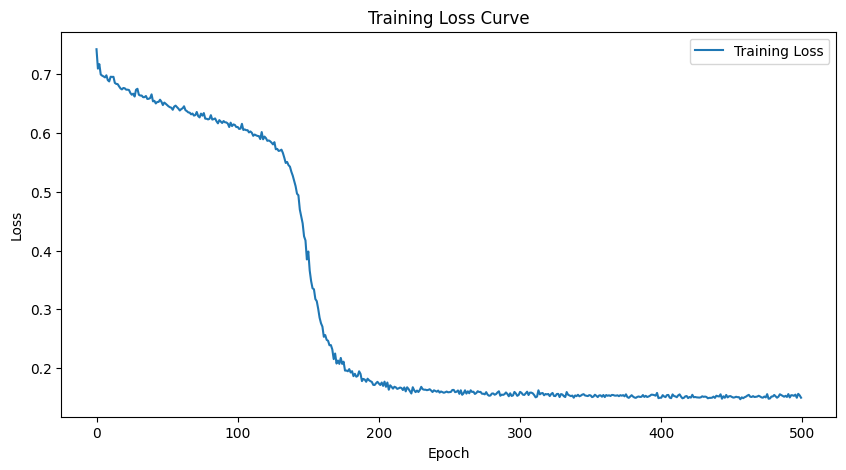

Best Model was saved at epoch 160 with accuracy 67.99%
Best Classification Report                   precision    recall  f1-score   support

    infringement       0.69      0.51      0.59       283
non_infringement       0.63      0.78      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.64       581



In [28]:

# Run main
main(model_name, non_infringement_file, infringement_file, checkpoint_file)
